# Imports

In [8]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from nilearn.masking import apply_mask,intersect_masks
from nilearn.plotting import plot_glass_brain
from nilearn.image import load_img,index_img

# Loading data

In [2]:
nb_subjects = 2
classes = ['vis_U','vis_D','vis_R','vis_L','aud_U','aud_D','aud_R','aud_L']
masks_names = ['vis_R','vis_L','aud_R','aud_L']

t_maps = [None]*nb_subjects
beta_maps = [None]*nb_subjects
X_all = [None]*nb_subjects
masks = [None]*nb_subjects

for i in range(nb_subjects): 
    t_maps[i]=load_img("brain_maps/sub"+str(i+1)+"_4D_t_maps_0.nii")
    beta_maps[i]=load_img("brain_maps/sub"+str(i+1)+"_4D_beta_0.nii")
    masks[i]=dict()
    for name in masks_names:
        masks[i][name]=load_img("masks/ROI_sub"+str(i+1)+"_"+name+".nii")


# Motion decoding

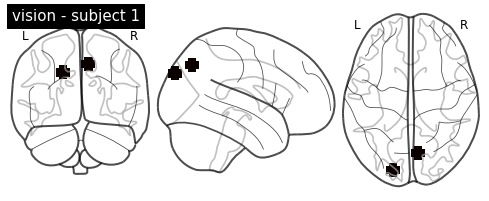

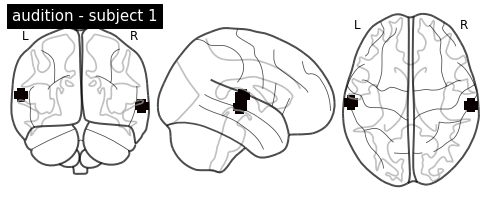

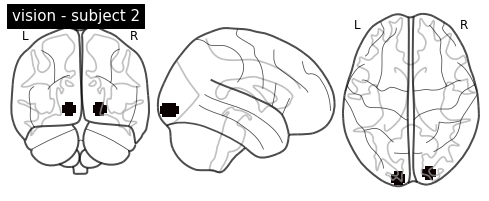

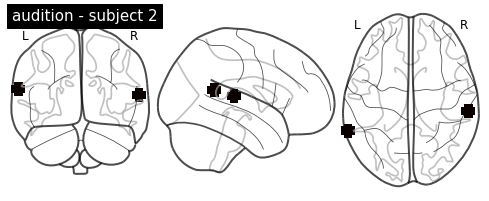

In [3]:
# 1. create and apply apply masks 
mask_vis=[None]*nb_subjects
mask_aud=[None]*nb_subjects
length = int(t_maps[0].shape[3]/2)
t_maps_masked_vis=[None]*nb_subjects
t_maps_masked_aud=[None]*nb_subjects


for i in range(nb_subjects):
    mask_vis[i] = intersect_masks([masks[i]['vis_R'],masks[i]['vis_L']],threshold=0,connected = False)
    mask_aud[i] = intersect_masks([masks[i]['aud_R'],masks[i]['aud_L']],threshold=0,connected = False)
    plot_glass_brain(mask_vis[i],title = "vision - subject "+str(i+1))
    plot_glass_brain(mask_aud[i],title = "audition - subject "+str(i+1))
    
    t_maps_masked_vis[i] = apply_mask(index_img(t_maps[i],range(length)),mask_vis[i])
    t_maps_masked_aud[i] = apply_mask(index_img(t_maps[i],range(length)),mask_aud[i])



In [4]:
# 2. create labels
class_labels = [None]*(length*2)
nb_runs = 12

for i in range(length*2) : 
    class_labels[i]=classes[i // nb_runs]
    
labels_vis = np.array(class_labels[:length])
labels_aud = np.array(class_labels[length:])

#### Visual motion 

In [15]:
classifier_vis = sklearn.svm.SVC(C=math.inf,kernel='linear') #default parameters, there is clearly improvements to be made here
n_splits = 6
kf = sklearn.model_selection.KFold(n_splits=n_splits,shuffle=True,random_state=1) 
scores=[]

for i in range(nb_subjects) :
    acc=0
    for train_index, test_index in kf.split(t_maps_masked_vis[i]):
        X_train,X_test = t_maps_masked_vis[i][train_index],t_maps_masked_vis[i][test_index]
        y_train,y_test = labels_vis[train_index],labels_vis[test_index]
        
        classifier_vis.fit(X_train,y_train)
        score = classifier_vis.score(X_test,y_test)
        acc += score
        
    scores.append(acc/n_splits)
        
for i in range(nb_subjects) :
    print("vision - cv score for subject "+str(i+1)+" is "+str(scores[i]))

vision - cv score for subject 1 is 0.3125
vision - cv score for subject 2 is 0.25


#### Auditory motion 

In [12]:
classifier_aud = sklearn.svm.SVC(C=math.inf') #default parameters, there is clearly improvements to be made here
n_splits = 6
kf = sklearn.model_selection.KFold(n_splits=n_splits,shuffle=True,random_state=1) 
scores=[]

for i in range(nb_subjects) :
    acc=0
    for train_index, test_index in kf.split(t_maps_masked_aud[i]):
        X_train,X_test = t_maps_masked_aud[i][train_index],t_maps_masked_aud[i][test_index]
        y_train,y_test = labels_aud[train_index],labels_aud[test_index]
        
        classifier_aud.fit(X_train,y_train)
        score = classifier_aud.score(X_test,y_test)
        acc += score
    scores.append(acc/n_splits)
        
for i in range(nb_subjects) :
    print("audition - cv score for subject "+str(i+1)+" is "+str(scores[i]))

audition - cv score for subject 1 is 0.20833333333333334
audition - cv score for subject 2 is 0.10416666666666667
